In [65]:
import os, sys
import matplotlib.pyplot as plt
import math
import numpy as np

# change as needed
sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
from OpenVisus import *

def Show(data,width=10):
	ratio=float(data.shape[1])/data.shape[0]
	fig = plt.figure(figsize = (width,width*ratio))
	ax = fig.add_subplot(1,1,1)
	ax.imshow(data, origin='lower')
	plt.show()

Define a python utility to extract arbitrary slices

In [63]:
# utility to extract a slice
def ExtractSlice(db, position,nlevels=1,quality=0, field=None,time=None, bShareMem=False):
    
    if field is None:
        field=db.getField()
    
    if time is None:
        time=db.getTime()
    
    pdim=db.getPointDim()
    max_resolution=db.getMaxResolution()
    
    access=db.createAccess()
    query = db.createPointQuery(position, field , time)

    resolutions=reversed([max_resolution + quality  - pdim*I for I in range(nlevels)])
    resolutions=[it for it in resolutions if it>0]
    for it in resolutions:
        query.end_resolutions.push_back(it)
        
    nsamples=db.guessPointQueryNumberOfSamples(Frustum(),query.logic_position, resolutions[-1])
    query.setPoints(nsamples)         
        
    db.beginPointQuery(query)    

    while query.isRunning():

        if not db.executePointQuery(access, query): break
        data=Array.toNumPy(query.buffer, bShareMem=False) 
        data=data[0,:,:] # it is a slice!
        yield data
        db.nextPointQuery(query)

Load the dataset

In [64]:
db=LoadDataset(r'D:\GoogleSci\visus_dataset\TALASS\ACAM\honeycomb.idx')
Width,Height,Depth=db.getLogicBox()[1]
print(Width,Height,Depth)

1407 389 1388


Extract a arbitrary slice.

Note 1: start always with a slice Z=0 (i.e. a full quad in 2-dimension) and use a Matrix to embed it into the 3-space

Note 2: there is a BUG with clipping planes if you go outside dataset boundaries

In [ ]:
"""
Translate(0,62,0)
    RotateX(30)
        Slice@Z=0
"""
T=Matrix.translate(PointNd(0,62,0))
R=Matrix.rotate(4,1,2,math.radians(30))
slice=BoxNd(PointNd(0,0,0),PointNd(Width,Height,0))

for data in ExtractSlice(db, Position(R,T,Position(slice)), nlevels=3, quality=-6):
    print("Got data", data.shape, data.dtype)
    Show(data) 

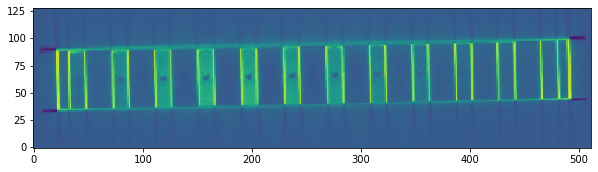

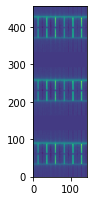

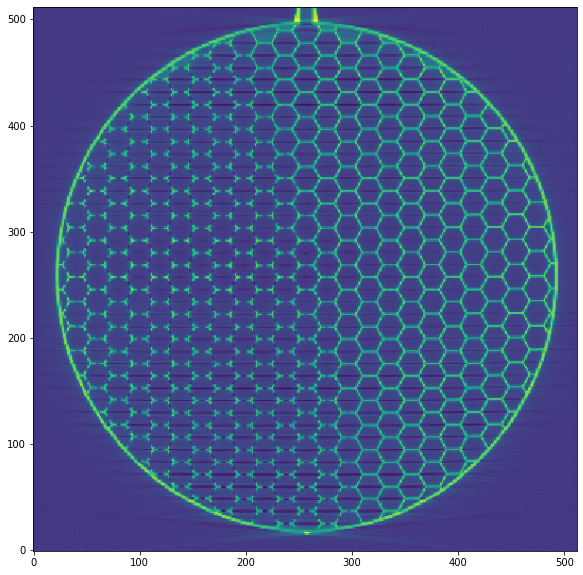

In [77]:
# utility to compute from points (possibly near each other)
# a Position to be used for slice extraction
# W,H are the size of the (alpha,beta) domain on Z=0 plane
def computeSlicePositionFromPoints(points,W,H,verbose=False):
    
    # compute centroid of the points
    centroid=[0,0,0]
    for point in points:
        centroid[0]+=point[0]/len(points)
        centroid[1]+=point[1]/len(points)
        centroid[2]+=point[2]/len(points)
    centroid=Point3d(centroid)

    # find the plane
    p12=points[1]-points[0]
    p13=points[2]-points[0]
    n=p12.cross(p13).normalized()

    X,Y,Z=Point3d(1,0,0),Point3d(0,1,0),Point3d(0,0,1)
    axis=n.cross(Z)
    if axis.module()==0:
        axis,angle=Point3d(0,0,1),0
    else:
        angle=math.acos(n.dot(Z))

    # transate from Zero to 'centroid'
    #   rotate to transform Z axis to 'n'
    #     move center of quad (W,H) to Zero
    T = Matrix.translate(PointNd(centroid)) * \
        Matrix.rotateAroundCenter(Point3d(0,0,0), axis, -angle) * \
        Matrix.translate(PointNd(-W/2,-H/2,0))
    
    box=BoxNd(PointNd(0,0,0),PointNd(W,H,0))
    
    if verbose:
        print("centroid",centroid.toString())
        print("normal", n.toString())
        print("rotation.axis",axis.toString())
        print("rotation.angle",math.degrees(angle))
        print("position.T",T.toString())
        print("position.box",box.toString())   

    return Position(T,Position(box))


# example Z slice
X,Y,Z=Width/2,Height/2,Depth/2
points = [
    Point3d(X  ,Y  ,Z),
    Point3d(X+1,Y  ,Z),
    Point3d(X  ,Y+1,Z)
]
w,h=Width,Height
for data in ExtractSlice(db, computeSlicePositionFromPoints(points,w,h), nlevels=1, quality=-6):
    Show(data) 
    
    
# example X slice
points = [
    Point3d(X,Y  ,Z  ),
    Point3d(X,Y+1,Z  ),
    Point3d(X,Y  ,Z+1)
]
w,h=[Height,Depth]
for data in ExtractSlice(db, computeSlicePositionFromPoints(points,w,h), nlevels=1, quality=-6):
    Show(data)     
    
# example Y slice
points = [
    Point3d(X  ,Y  ,Z  ),
    Point3d(X+1,Y  ,Z  ),
    Point3d(X  ,Y  ,Z+1)
]
w,h=[Width,Depth]
for data in ExtractSlice(db, computeSlicePositionFromPoints(points,w,h), nlevels=1, quality=-6):
    Show(data) 